In [13]:
import numpy as np

In [47]:
def RGB_to_Y(image):
    Y = 0.299*image[:,:,0]+0.587*image[:,:,1]+0.114*image[:,:,2]
    Cb = -0.1687*image[:,:,0]- 0.3313*image[:,:,1]+0.5*image[:,:,2] +128
    Cr = 0.5*image[:,:,0]- 0.4187*image[:,:,1]- 0.0813*image[:,:,2] +128
    return (Y, Cb, Cr)

In [48]:
def subsample(block):
    from torch.nn import AvgPool2d
    from torch import Tensor
    
    t_block = Tensor(block)
    t_block.unsqueeze_(0)

    pool = AvgPool2d(3, stride = 1, padding = 1)
    
    res = pool(t_block)

    return res.squeeze_(0).numpy()

In [49]:
def dct_block(block):
    
    from cv2 import dct
    
    res = dct(block)
    
    return res

In [50]:
def get_blocks(image):
    
    blocks = []
    
    size_new = max(image.shape) + (8 - max(image.shape) % 8)
    array = np.zeros([size_new, size_new])
    array[(size_new - image.shape[0])// 2 : (size_new + image.shape[0])//2, \
      (size_new - image.shape[1])//2 : (size_new + image.shape[1])//2 ] = image
    
    for x in range (array.shape[0] // 8):
        for y in range (array.shape[1] // 8):
            block_new = array[y*8:(y+1)*8,x*8:(x+1)*8]
    
            blocks.append(block_new)
    
    return blocks

In [51]:
def zig_zag_arr(matrix):
    rows, columns = matrix.shape[0], matrix.shape[1]
    
    solution=[[] for i in range(rows+columns-1)]

    for i in range(rows):
        for j in range(columns):
            sum=i+j
            if(sum%2 ==0):
                solution[sum].insert(0,matrix[i][j])
            else:
                solution[sum].append(matrix[i][j])
                
    flatten = lambda t: [item for sublist in t for item in sublist]
    res = flatten(solution)
    res = [int(abs(r)) for r in res]
    return res

In [52]:
def quant(block, y = True):
    
    quant_y = [[160,  110,  110,  160,  240,  255,  255,  255],
    [120,  120,  140,  190,  255,  255,  255,  255],
    [140,  130,  160,  240,  255,  255,  255,  255],
    [140,  170,  220,  255,  255,  255,  255,  255],
    [180,  220,  255,  255,  255, 255, 255,  255],
    [240,  255,  255,  255,  255, 255, 255,  255],
    [255,  255,  255,  255, 255, 255, 255, 255],
    [255,  255,  255,  255, 255, 255, 255,  255]]
    
    quant_c = [[17,  18,  24,  47,  99,  99,  99,  99],
    [18,  21,  26,  66,  99,  99,  99,  99],
    [24,  26,  56,  99,  99,  99,  99,  99],
    [47,  66,  99,  99,  99,  99,  99,  99],
    [99,  99,  99,  99,  99,  99,  99,  99],
    [99,  99,  99,  99,  99,  99,  99,  99],
    [99,  99,  99,  99,  99,  99,  99,  99],
    [99,  99,  99,  99,  99,  99,  99,  99]]
    
    if y:
        return np.round(block / quant_y, decimals = 0)
    else:
        return np.round(block / quant_c, decimals = 0)

In [53]:
def Compress_Jpeg(image, path_exit):
    import os 
    import numpy as np
    import zlib
    
    res = []
    
    Y, Cb, Cr = RGB_to_Y(image)
    Y_blocks = get_blocks(Y)
    Cb_blocks = get_blocks(Cb)
    Cr_blocks = get_blocks(Cr)
    
    for i in range(len(Y_blocks)):
        
        Y = Y_blocks[i]
        Cb = Cb_blocks[i]
        Cr = Cr_blocks[i]

        Cb = subsample(Cb)
        Cr = subsample(Cr)

        Y_dct = dct_block(Y)
        Cb_dct = dct_block(Cb)
        Cr_dct = dct_block(Cr)
        
        Y_block = quant(Y_dct)
        Cb_block = quant(Cb_dct, False)
        Cr_block = quant(Cr_dct, False)
        
        Y_flat = zig_zag_arr(Y_block)
        Cb_flat = zig_zag_arr(Cb_block)
        Cr_flat = zig_zag_arr(Cr_block)
        
        res += (Y_flat + Cb_flat + Cr_flat)
    
    print (max(res), min(res) )
    compressed_data = zlib.compress(bytes(res))   
    
    os.mkdir(path_exit + r'\zipped')
    f = open(path_exit + r'\zipped'+ r'\zip.txt', 'wb')
    f.write(compressed_data)
        
    return 'Done'

In [54]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

In [55]:
img = mpimg.imread('Example.jpeg')

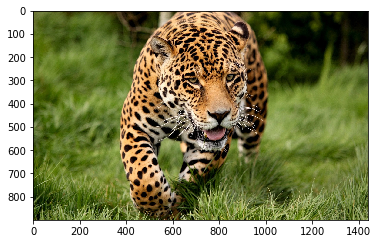

In [56]:
plt.imshow(img)

In [57]:
Compress_Jpeg(img,  r'C:\Users\Денис\Desktop')

68 0


'Done'

In [186]:
def Huff(l):
    
    from collections import Counter
    class node:
        code = None
        value = 0
        left = None
        right = None
        def __lt__(self, other):
            self.value < other.value
    
    def dfs(n, huff, c = ''):
        if n.code is not None:
            huff[n.code] = c
        if n.left:
            dfs(n.left, huff, c + '1')
        if n.right:
            dfs(n.right, huff, c + '0')
            
    node_list = []

    for key, value in Counter(l).most_common():
        n = node()
        n.code = key
        n.value = value
        node_list.append(n)
    
    while len(node_list) > 1:
        node_list.sort()
        n1 = node_list[0]
        n2 = node_list[1]
        n3 = node()
        n3.value = n1.value + n2.value
        n3.left = n1
        n3.right = n2
        node_list.remove(n1)
        node_list.remove(n2)
        node_list.append(n3)
        
    huff = {}

    dfs(node_list[0], huff)
    
    encoded = []
    for i in l:
        encoded += str(huff[i])
    return encoded